In [39]:
ON_COLAB = True

if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
# other
import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path
import pandas as pd
import imageio
from csv import writer
from PIL import Image

# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [78]:
# Turn the folder of txt files in a Pandas Dataframe
txt_path = 'drive/Othercomputers/Il mio laptop/baseline/poses_txt'

def get_nth_line(fobj, n):
    for i in range(n):
        next(fobj)
    return next(fobj)

columns = ['filename', 'x', 'y', 'z', 'roll', 'pitch', 'yaw']
df_master = pd.DataFrame(columns=columns)

with open('drive/Othercomputers/Il mio laptop/baseline/poses.csv', 'w') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(columns)
    for f in Path(txt_path).iterdir():
        filename = str(f).split('/')[-1].split('.txt')[0] + '-N_.png'
        file = open(f)
        line4 = get_nth_line(file, 4)
        line_splitted = line4.split(' ')
        writer_object.writerow([filename] + line_splitted)
    f_object.close()

In [134]:
class PoseDataset(Dataset):

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        poses = pd.read_csv(csv_file)
        self.poses = poses.sort_values(by=["filename"], ascending=False)
        print('self.poses', self.poses)
        self.root_dir = root_dir
    

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                self.poses.iloc[idx, 0])
        img = Image.open(img_path)
        rgb_img = img.convert('RGB')
        transform = transforms.Compose([transforms.PILToTensor()])
        img_tensor = transform(rgb_img)
        print(img_tensor)
        pose = self.poses.iloc[idx, 1:]
        pose = np.array([pose])
        
        return rgb_img, pose

In [135]:
pose_dataset = PoseDataset(csv_file = 'drive/Othercomputers/Il mio laptop/baseline/poses.csv',
                           root_dir='drive/Othercomputers/Il mio laptop/baseline/RGB_images')

self.poses          filename           x           y          z        roll      pitch  \
999    999-N_.png  250.544739 -140.605148  54.904602 -105.519623 -61.704853   
998    998-N_.png  131.591812  -77.576637 -31.677343 -164.633804 -61.190624   
997    997-N_.png   72.182510   -6.655201  45.589375  -97.842354 -59.892162   
996    996-N_.png  350.472412  138.565720 -50.711277 -120.846764 -51.575020   
995    995-N_.png  387.060120  -42.638580  15.343819 -112.368439 -57.916286   
...           ...         ...         ...        ...         ...        ...   
7002  1000-N_.png  126.977669  -25.676477 -82.227676 -132.231842 -47.297482   
7001   100-N_.png  118.010986   85.921097 -50.328716 -100.272568 -70.722870   
7000    10-N_.png  295.404236   25.647936 -80.327667 -157.664032 -54.409801   
8001     1-N_.png  219.377014  -73.048820  47.229362 -125.215286 -71.151596   
8000     0-N_.png  303.329285   89.407677 -11.472251 -104.222527 -72.607857   

             yaw  
999    81.130051  
99

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
[[250.544739 -140.605148 54.904602 -105.519623 -61.704853 81.130051]]


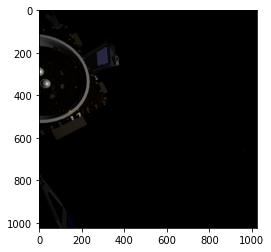

In [132]:
img, pose = pose_dataset[0]
print(pose)
plt.figure()
plt.imshow(img)
plt.show()

In [136]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean.tolist(), std.tolist()),
    ]
)

# Create train val split
n = len(pose_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(
    pose_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set)) #, len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number!
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size,
                        shuffle=True, num_workers=2)
#loader_test = DataLoader(
#    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


7202 800


In [137]:
### TO DO ### UNDERSTAND IF THE MEAN AND STD SHOULD BE DIFFERENT WRT THE OTHER EXAMPLE AND IF YES HOW

unnormalize = transforms.Normalize(
    (-mean / std).tolist(), (1.0 / std).tolist())


def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x


def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).clip(0, 1))


In [139]:
# define resnet2 building blocks

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))
        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding=0, bias=False),
                                          nn.BatchNorm2d(outchannel))

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# define resnet

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=6):
        super(ResNet, self).__init__()

        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=1)
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.maxpool2 = nn.MaxPool2d(2, stride=1, padding=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.maxpool2(x)
        x = self.layer2(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.maxpool2(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# please do not change the name of this class
# Got 1315 / 1998 correct of val set (65.82)

def MyResNet():
    return ResNet(ResidualBlock)

In [140]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
    labels = ['x', 'y', 'z', 'roll', 'pitch', 'yaw']
    # Plotting the confusion matrix
    cm = confusion_matrix(
        y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    sns.heatmap(cm, annot=True, ax=ax)  # annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels, rotation=70)
    ax.yaxis.set_ticklabels(labels, rotation=0)
    plt.show()


def incorrect_preds(preds, y, test_img):
    labels = ['x', 'y', 'z', 'roll', 'pitch', 'yaw']
    # lets see a sample of the images which were classified incorrectly!
    correct = (preds == y).float()
    test_labels_check = correct.cpu().numpy()
    incorrect_indexes = np.where(test_labels_check == 0)

    test_img = test_img.cpu()
    samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                        padding=2, normalize=False, value_range=None,
                        scale_each=False, pad_value=0)
    plt.figure(figsize=(20, 10))
    plt.title('Incorrectly Classified Instances')
    show(samples)
    labels = np.asarray(labels)
    print('Predicted label',
          labels[preds[incorrect_indexes].cpu().numpy()[:9]])
    print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
    print('Corresponding images are shown below')


In [141]:
USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)


print_every = 10


def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set

    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
                stack_labels = y
                stack_predicts = preds
            elif analysis:
                stack_labels = torch.cat([stack_labels, y], 0)
                stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' %
              (num_correct, num_samples, 100 * acc))
        if analysis:
            print('check acc', type(stack_predicts), type(stack_labels))
            confusion(stack_predicts, stack_labels)
            incorrect_preds(preds, y, x)
        return float(acc)


def train_part(model, optimizer, epochs=1):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    iter_val = iter(loader_val)
    losses = []
    val_losses = []

    for e in range(epochs):
        counts = torch.zeros((20,), device=device, dtype=torch.long)
        for t, (x, y) in enumerate(loader_train):

            try:
                x_val, y_val = next(iter_val)
            except StopIteration:
                iter_val = iter(loader_val)
                x_val, y_val = next(iter_val)

            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            x_val = x_val.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y_val = y_val.to(device=device, dtype=torch.long)
            
            counts.index_add_(0,torch.unique(y, return_counts=True)[0],torch.unique(y, return_counts=True)[1])

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            losses.append(loss.item())

            scores_val = model(x_val)
            val_loss = F.cross_entropy(scores_val, y_val)
            val_losses.append(val_loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            
            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                
        check_accuracy(loader_val, model)

        print("data counts", counts/torch.sum(counts))

    plt.figure(figsize=(10,7))
    plt.title("Learning curve")
    plt.plot(losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.legend()
    plt.savefig('learning_curve.png', bbox_inches='tight', dpi=150)
    plt.show()


cpu


In [142]:
# define and train the network
torch.autograd.set_detect_anomaly(True)
model = MyResNet()
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-7)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs=10)

losses = []
val_losses = []

# report test set accuracy
check_accuracy(loader_val, model, analysis=True)

# save the model
torch.save(model.state_dict(), 'model.pt')


Output streaming troncato alle ultime 5000 righe.

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
tensor([[[0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 6, 6, 6],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 6, 6, 6],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 6, 6, 6],
         [0, 0, 0,  ..., 6, 6, 6],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
tensor(

TypeError: ignored

tensor([[[120, 117, 115,  ...,   0,   0,   0],
         [120, 118, 116,  ...,   0,   0,   0],
         [120, 118, 116,  ...,   0,   0,   0],
         ...,
         [ 76,  75,  82,  ...,   0,   0,   0],
         [ 77,  78,  85,  ...,   0,   0,   0],
         [ 79,  80,  88,  ...,   0,   0,   0]],

        [[126, 124, 121,  ...,   0,   0,   0],
         [126, 124, 122,  ...,   0,   0,   0],
         [126, 124, 122,  ...,   0,   0,   0],
         ...,
         [ 91,  91,  98,  ...,   0,   0,   0],
         [ 92,  93, 100,  ...,   0,   0,   0],
         [ 94,  95, 102,  ...,   0,   0,   0]],

        [[144, 143, 141,  ...,   0,   0,   0],
         [145, 143, 142,  ...,   0,   0,   0],
         [145, 143, 142,  ...,   0,   0,   0],
         ...,
         [ 81,  81,  89,  ...,   0,   0,   0],
         [ 83,  84,  91,  ...,   0,   0,   0],
         [ 85,  86,  94,  ...,   0,   0,   0]]], dtype=torch.uint8)
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0

In [ ]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)
